# Using NEXRAD data

In this notebook we'll use the [`xarray`](xarray.pydata.org/) package, as well as the local `nexrad` package, to examine the Nexrad precipitation data.
For more information on the dataset, see the README file or the docs.

In [1]:
import cartopy.crs as ccrs  # for mapping
from cartopy.feature import STATES
import dask
import matplotlib.pyplot as plt  # for plotting
import xarray as xr  # for gridded data

from datetime import datetime

from nexrad import TimeRange, get_nc_fname

To start with, let's define the temporal range that we want to look at.
We'll look at a 24 hour time period, just for illustration.

In [2]:
trange = TimeRange(datetime(2017, 8, 26, 0), datetime(2017, 8, 26, 23))

Now we can start loading the data in.
We need to define the folder where the data is located.
See the [documentation](https://kb.rice.edu/page.php?id=108256) for the Rice RDF to learn how to mount the folder on your machine.

In [3]:
data_dir = "/Volumes/research/jd82/nexrad/"

We can use the `nexrad` package to get the filename corresponding to each timestep we want.

In [4]:
fnames = [get_nc_fname(dt, dirname=data_dir) for dt in trange.dts]
len(fnames)

24

## Single snapshots

The data is organized so that one file corresponds to one time step (hourly).
The first way to use xarray is to work with a single file.

Note that we are explicitly writing the `.name` attribute here.
We can play around with this `xarray.DataArray` object.

In [5]:
snapshot = xr.open_dataarray(fnames[0])
snapshot.name = "prcp_mm"
snapshot

<xarray.DataArray 'prcp_mm' (time: 1, alt: 1, lat: 3500, lon: 7000)>
[24500000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-08-26
  * lon      (lon) float64 230.0 230.0 230.0 230.0 ... 300.0 300.0 300.0 300.0
  * lat      (lat) float64 54.99 54.98 54.97 54.96 ... 20.03 20.02 20.01 20.0
  * alt      (alt) float64 0.0

One of the best things we can do with an xarray object is plot it!
For more on plotting with xarray and cartopy, see [the docs](https://docs.xarray.dev/en/stable/user-guide/plotting.html).

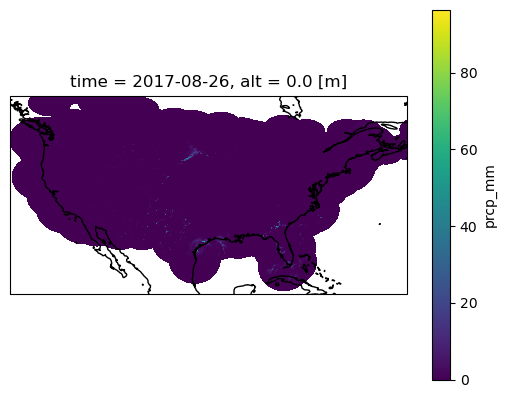

In [6]:
p1 = snapshot.plot(
    subplot_kws=dict(
        projection=ccrs.PlateCarree(),  # desired map
        transform=ccrs.PlateCarree(),  # data projection
    )
)
p1.axes.coastlines()
plt.draw()

We can also subset data!

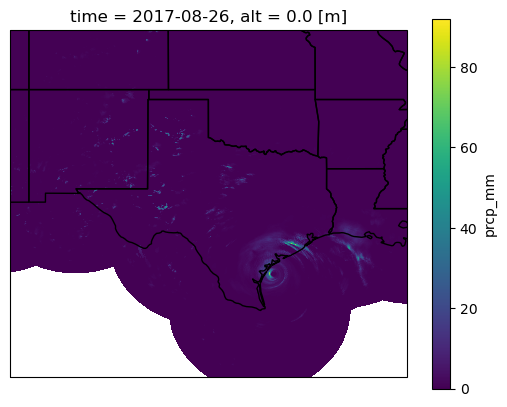

In [7]:
p2 = snapshot.sel(lon=slice(250, 270), lat=slice(40, 22.5)).plot(
    subplot_kws=dict(
        projection=ccrs.PlateCarree(),  # desired map
        transform=ccrs.PlateCarree(),  # data projection
    )
)
p2.axes.add_feature(STATES)
plt.draw()

## Multiple snapshots

Often we want to work with multiple snapshots at once.
To do this, we can use the multi-file functionality of xarray.
This uses dask as a backend for lazy loading.
For more, see [the docs](https://docs.xarray.dev/en/stable/user-guide/dask.html)!

Note that we `rename` the data variable because the default variable created is not very informative.

In [8]:
dask.config.set({"array.slicing.split_large_chunks": True})

In [9]:
ds = (
    xr.open_mfdataset(
        fnames,  # defined above
        combine="nested",
        concat_dim="time",
    )
    .rename({"param9.6.209": "prcp_mm"})
    .sortby("time")
    .sel(lon=slice(250, 270), lat=slice(40, 22.5))
)
ds

<xarray.Dataset>
Dimensions:  (time: 24, lon: 2000, lat: 1750, alt: 1)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-26 ... 2017-08-26T23:00:00
  * lon      (lon) float64 250.0 250.0 250.0 250.0 ... 270.0 270.0 270.0 270.0
  * lat      (lat) float64 39.99 39.98 39.97 39.96 ... 22.53 22.52 22.51 22.5
  * alt      (alt) float64 0.0
Data variables:
    prcp_mm  (time, alt, lat, lon) float32 dask.array<chunksize=(1, 1, 1750, 2000), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Oct 11 01:06:14 2022: cdo -r -f nc4 -z zip_1 setctomiss...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

As before, we can subset our data, perform computations, or create plots.
Here we can select six (arbitrary!) time steps to plot.

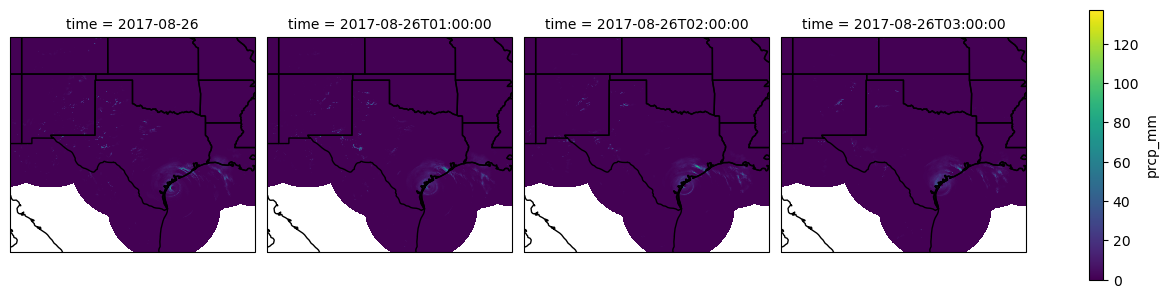

In [10]:
p3 = ds.isel(time=slice(0, 4))["prcp_mm"].plot(
    transform=ccrs.PlateCarree(),
    col="time",
    subplot_kws={"projection": ccrs.PlateCarree()},
)

for ax in p3.axes.flat:
    ax.coastlines()
    ax.add_feature(STATES)

plt.draw()